In [1]:
import torch
from diffusers import UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from transformers import CLIPTokenizer, CLIPTextModel
from PIL import Image
import torch.nn.functional as F
import os

def generate_image(prompt, num_inference_steps=50, guidance_scale=7.5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load models
    model_path = "./ldm_checkpoints/epoch_4"
    
    # Initialize models
    unet = UNet2DConditionModel.from_pretrained(
        os.path.join(model_path, "unet"),
        use_safetensors=True
    ).to(device)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
    scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")
    
    # Load training state if needed
    checkpoint = torch.load(os.path.join(model_path, "training_state.pth"), map_location=torch.device('cpu'))
    unet.load_state_dict(checkpoint['model_state_dict'])
    
    # Set to evaluation mode
    unet.eval()
    text_encoder.eval()
    vae.eval()
    
    # Encode text
    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    # Create uncond input for classifier free guidance
    uncond_input = tokenizer(
        [""] * 1,  # empty string for unconditional guidance
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids)[0]
        uncond_embeddings = text_encoder(uncond_input.input_ids)[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialize random latents
    latents = torch.randn(
        (1, 4, 64, 64)  # Make sure these dimensions match your training
    ).to(device)
    
    latents = latents * scheduler.init_noise_sigma
    
    # Denoising loop
    scheduler.set_timesteps(num_inference_steps)
    
    for t in scheduler.timesteps:
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        
        # Scale latents according to timestep
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        # Predict noise residual
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings
            ).sample
        
        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Decode latents to image
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    
    # Process image
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")
    image = Image.fromarray(image[0])
    
    return image



C:\Users\vishw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\vishw\AppData\Local\Temp\ipykernel_45124\2373564208.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(model_path, "training_

Generated image saved as 'generated_images/generated.png'


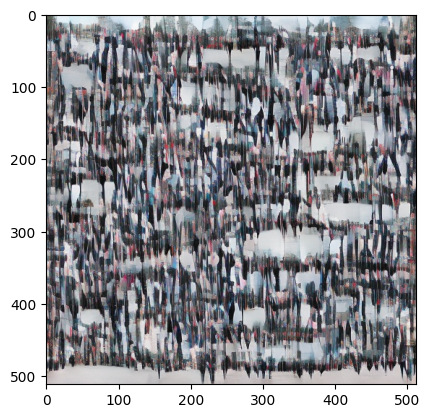

In [ ]:
# Example usage
import matplotlib.pyplot as plt

prompt = "Group of people walking"
image = generate_image(
        prompt=prompt,
        num_inference_steps=50,  # Increase for better quality, decrease for speed
        guidance_scale=7.5  # Adjust for creativity vs prompt adherence
    )
    
    # Save the generated image
os.makedirs("generated_images", exist_ok=True)
image.save("generated_images/generated.png")
print(f"Generated image saved as 'generated_images/generated.png'")
plt.imshow(image)